In [10]:
from bauer.utils.data import load_garcia2022

import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import aesara.tensor as at

In [11]:
df = load_garcia2022()

In [12]:
def get_posterior(mu1, sd1, mu2, sd2):
    var1, var2 = sd1**2, sd2**2
    return mu1 + (var1/(var1+var2))*(mu2 - mu1), np.sqrt((var1*var2)/(var1+var2))

def get_diff_dist(mu1, sd1, mu2, sd2):
    return mu2 - mu1, np.sqrt(sd1**2+sd2**2)

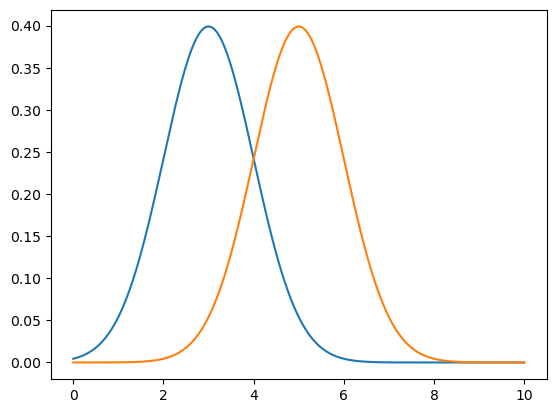

In [13]:
mu_1, sd_1, mu_2, sd_2 = 3.0, 1.0, 5.0, 1.0


dist1 = ss.norm(mu_1, sd_1)
dist2 = ss.norm(mu_2, sd_2)

x = np.linspace(0, 10, 1000)

plt.plot(x, dist1.pdf(x))
plt.plot(x, dist2.pdf(x))

In [14]:
mu_diff, sd_diff = get_diff_dist(mu_1, sd_1, mu_2, sd_2)

mu_diff, sd_diff

(2.0, 1.4142135623730951)

0.07864960352514258

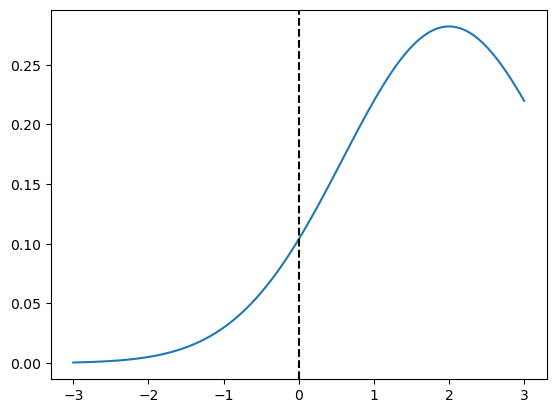

In [15]:
x = np.linspace(-3, 3, 100)
plt.plot(x, ss.norm(mu_diff, sd_diff).pdf(x))
plt.axvline(0.0, c='k', ls='--')

ss.norm(mu_diff, sd_diff).cdf(0.0)

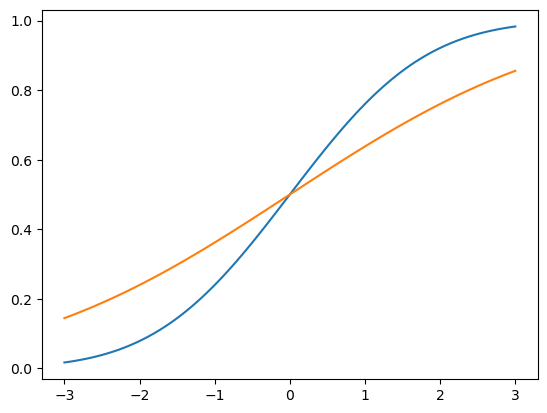

In [16]:
plt.plot(x, ss.norm(-x, sd_diff).cdf(0))
plt.plot(x, ss.norm(-x, sd_diff*2).cdf(0))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_7248/184050746.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['q(x)'] = pd.qcut(tmp['log(n2/n1)'], 6).apply(lambda x: x.mid)


<Axes: xlabel='q(x)', ylabel='choice'>

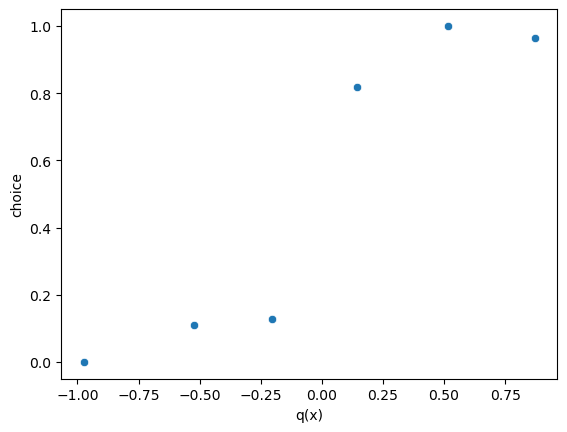

In [17]:
tmp = df.loc[1]

import seaborn as sns
import pandas as pd

tmp['q(x)'] = pd.qcut(tmp['log(n2/n1)'], 6).apply(lambda x: x.mid)

tmp = tmp.groupby(['q(x)']).mean()[['choice']]

sns.scatterplot(tmp.reset_index(), x='q(x)', y='choice')
# sns.scatterpl(tmp.reset_index(), 'log(n1/n2)', 'choice')

In [28]:
def poly_sigma_mapping(x, pars):
    return pars[0] + pars[1] * x + pars[2] * x**2 

In [18]:
def get_choice_prob(x, sigma):
    p = 1-ss.norm(x, sigma).cdf(0.0)
    return p

In [19]:
def get_likelihood(x, sigma, choices):

    p = get_choice_prob(x, sigma)

    return np.sum(np.log(ss.bernoulli(p).pmf(choices)))

In [20]:
from scipy.optimize import minimize

In [21]:
def make_cost_function(x, choices):
    def cost(pars):
        return -get_likelihood(x, pars[0], choices)
    return cost

In [22]:
def fit_simple_probit(x, choices):
    cost = make_cost_function(x, choices)
    result = minimize(cost, [5.0], bounds=[(1e-6, np.inf)], method='L-BFGS-B')
    return result

array([2.37456699])

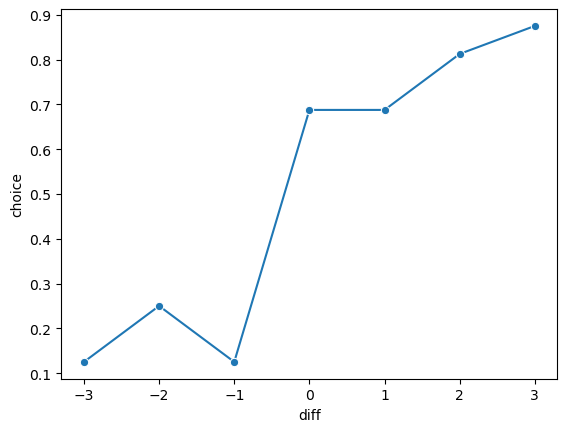

In [23]:
sigma = 2.5

x = np.array([-3, -2, -1, 0.0, 1, 2, 3] * 16)
choices = ss.norm(x, sigma).rvs() 
choices = choices > 0.0

simulated_data = pd.DataFrame({'diff':x, 'choice':choices})

tmp = simulated_data.groupby('diff').mean()
sns.lineplot(tmp.reset_index(), x='diff', y='choice', marker='o')

# cost = make_cost_function(x, choices)
# result = minimize(cost, [1.0], bounds=[(1e-6, np.inf)], method='L-BFGS-B')
# result.x
fit_simple_probit(x, choices).x

In [24]:
sigma_est = df.groupby('subject').apply(lambda d: fit_simple_probit(d['log(n2/n1)'], d['choice']).x[0])

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_7248/1603860628.py:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(ss.bernoulli(p).pmf(choices)))
/Users/gdehol/mambaforge/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_7248/2251397983.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sigma_est)


<Axes: ylabel='Density'>

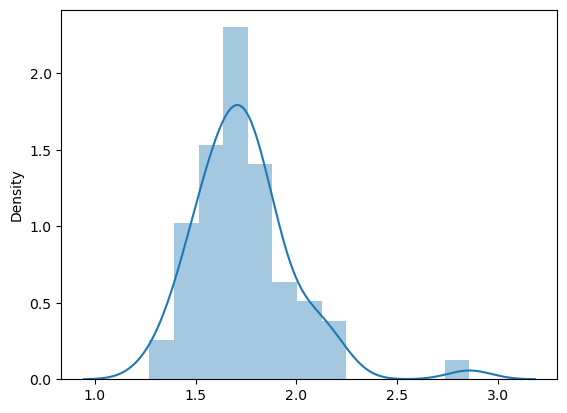

In [25]:
sns.distplot(sigma_est)

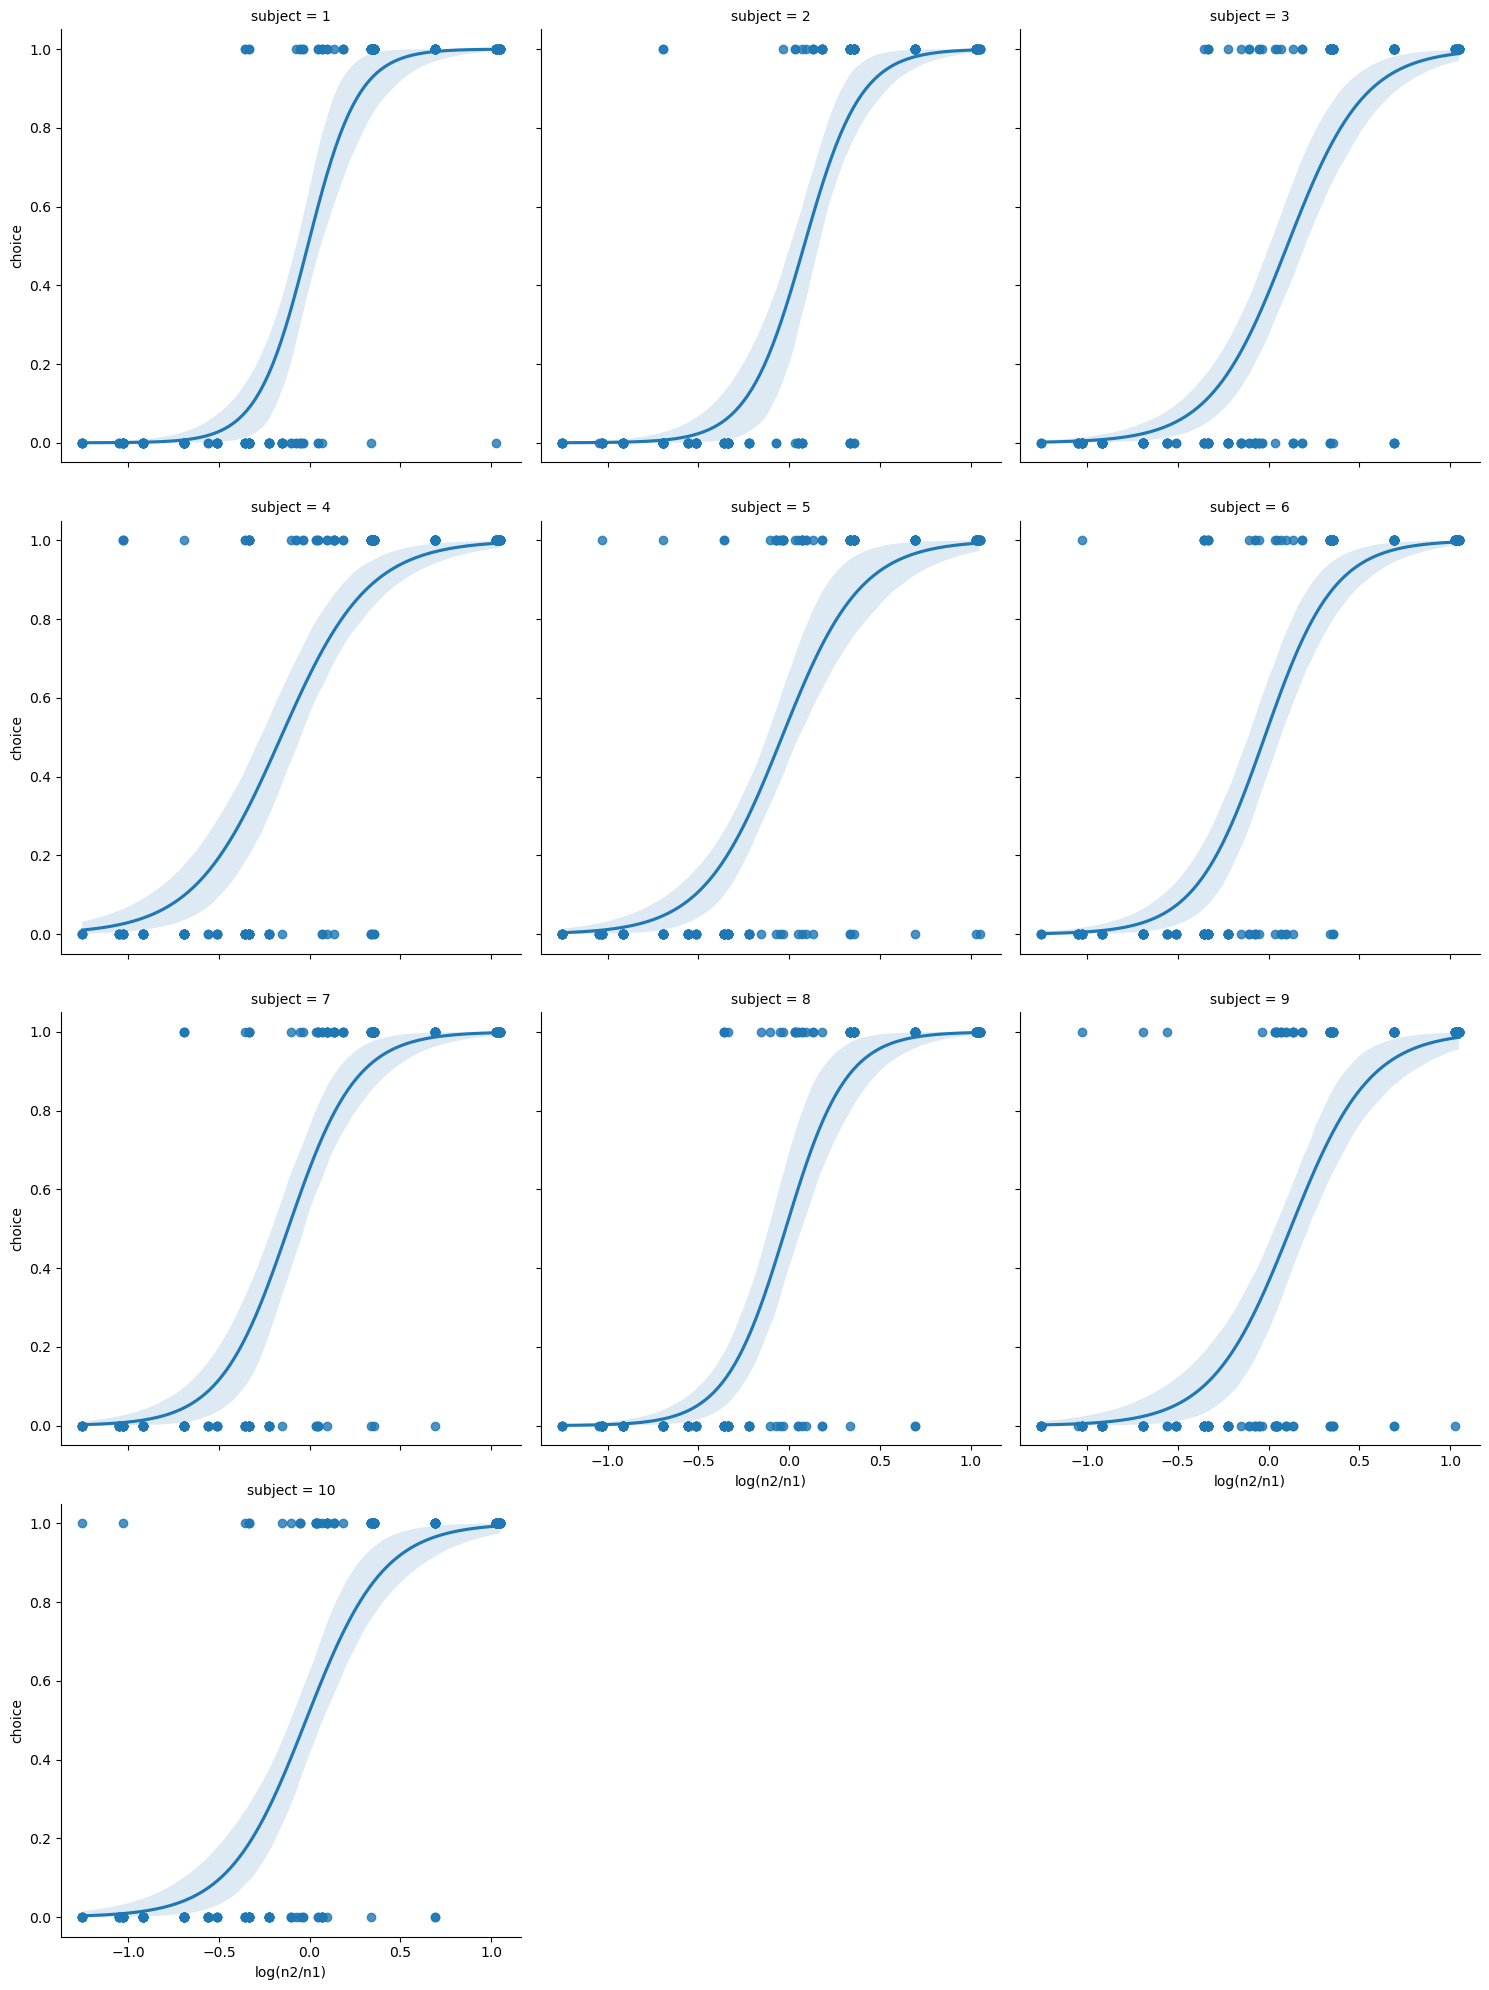

In [26]:
sns.lmplot(df.loc[:10].reset_index(), x='log(n2/n1)', y='choice', logistic=True, col='subject', col_wrap=3)

In [27]:
sigma_est.loc[:10]

subject
1     1.724796
2     1.725708
3     1.868547
4     1.935367
5     1.940349
6     1.803112
7     1.754246
8     1.581184
9     2.068494
10    1.829780
dtype: float64